In [1]:
import os
import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt 

import pystac_client
import planetary_computer

import rasterio
from rasterio.merge import merge
from rasterio.plot import show

from utils import (
    read_geojson, 
    download_urls,
)

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [4]:
# startDate = '2017-03-26'
# endDate = '2023-03-01'
# geojson_filepath = 'geojsons/duck.geojson'
# save_dir = os.path.join('naip', os.path.basename(geojson_filepath).split('.')[0], 'tiles')

startDate = '2012-01-01'
endDate = '2012-12-31'
geojson_filepath = '/home/connor/repos/aerial-auto-segment/geojsons/northfield.geojson'
# save_dir = os.path.join('/data/chesapeake_bay_lulc/naip/', os.path.basename(geojson_filepath).split('.')[0], 'tiles')
save_dir = os.path.join('/data/microsoft_planetary_computer/naip/', os.path.basename(geojson_filepath).split('.')[0], 'tiles')


In [5]:
bounding_polygon = read_geojson(geojson_filepath)
time_range = "{}/{}".format(startDate, endDate)

search = catalog.search(collections=["naip"], intersects=bounding_polygon['geometry'], datetime=time_range)
items = search.get_all_items()
item_old2new = sorted(items, key=lambda x: x.properties['datetime'], reverse=True)

titles_urls = [(x.id, x.assets["image"].href) for x in items]
print(titles_urls)

/home/connor/mambaforge/envs/autoseg/lib/python3.11/site-packages/pystac_client/item_search.py:850: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


[('ca_m_3411856_sw_11_1_20120505_20120627', 'https://naipeuwest.blob.core.windows.net/naip/v002/ca/2012/ca_100cm_2012/34118/m_3411856_sw_11_1_20120505.tif?st=2024-03-04T02%3A11%3A45Z&se=2024-03-05T02%3A56%3A45Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2024-03-04T19%3A49%3A01Z&ske=2024-03-11T19%3A49%3A01Z&sks=b&skv=2021-06-08&sig=EngsH0I8s6agLx5I2s8itsSr/1YaW%2B3hHfcE9c8iouY%3D'), ('ca_m_3411855_se_11_1_20120505_20120627', 'https://naipeuwest.blob.core.windows.net/naip/v002/ca/2012/ca_100cm_2012/34118/m_3411855_se_11_1_20120505.tif?st=2024-03-04T02%3A11%3A45Z&se=2024-03-05T02%3A56%3A45Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2024-03-04T19%3A49%3A01Z&ske=2024-03-11T19%3A49%3A01Z&sks=b&skv=2021-06-08&sig=EngsH0I8s6agLx5I2s8itsSr/1YaW%2B3hHfcE9c8iouY%3D')]


In [6]:
download_urls(titles_urls, save_dir=save_dir)

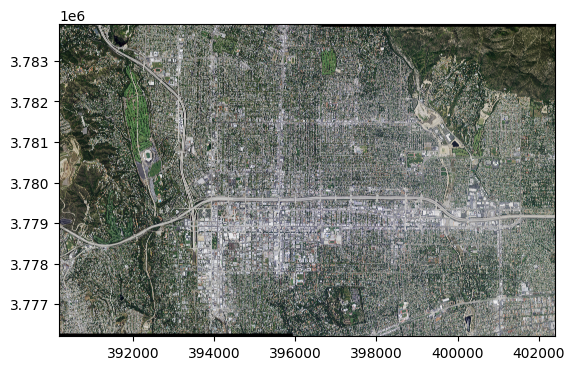

<Axes: >

In [9]:

files = glob.glob('/data/microsoft_planetary_computer/naip/{}/tiles/*.tiff'.format(save_dir.split(os.path.sep)[-2]))
dss = [rasterio.open(f) for f in sorted(files)]
ds, tform = merge(dss, nodata=0)

out_meta = dss[0].meta.copy()
out_meta.update({
    "driver": "GTiff",
    "height": ds.shape[1],
    "width": ds.shape[2],
    "transform": tform,
    "crs": dss[0].crs
})

mosaic_dir = save_dir.replace('tiles', 'mosaic')
os.makedirs(mosaic_dir, exist_ok=True)
mosaic_save_path = os.path.join(mosaic_dir, 'mosaic.tiff')
with rasterio.open(mosaic_save_path, 'w', **out_meta) as dest:
    dest.write(ds)

x = rasterio.open(mosaic_save_path)
show(x)